## Block model: Accelerating single-spike spiking neural network training

Spiking neural networks (SNNs) are an exciting avenue towards building more brain-like neural networks. From the point of neuroscience, these networks are great for modelling the brain on computers. From an engineering perspective, these networks are of interest due to their power efficiency (if emulated on special hardware known as a neuromorphic computer). SNNs in which individual neurons spike at most once obtain extreme energy efficiency, as energy utilisation scales approximately proportial to the number of emitted spikes. To date, training such single-spike SNNs has been difficult, slow and bounded to simple non-temporally complex problem domains. The block model aims to overcome these shortcomings, which we demonstrate in this tutorial.

## 1. Single-spike spiking neural networks: Standard and block model

Here we show that the both the standard single-spike and block model perform the same transformation i.e. for a given input they both produce the same output. However, the models differ in how they perform their computation, where the standard model uses slow sequential operations and the block model uses fast convolutional ones (see paper for theory).

In [78]:
import torch
torch.manual_seed(42)
import seaborn as sns
import matplotlib.pyplot as plt

from block.nn import methods
from block.nn.layers import LinearNeurons

In [79]:
n_in = 10  # Number of input neurons
n_out = 1  # Number of hidden neurons
t_len = 128  # Number of simulation time-steps

# Define both the standard single-spike and block model
# We use the same presynaptic weights for both model to demonstrate that they perform the same transformation
standard_model = LinearNeurons(n_in=n_in, n_out=n_out, method="standard", t_len=t_len, integrator=False, single_spike=True)
block_model = LinearNeurons(n_in=n_in, n_out=n_out, method="fast_naive", t_len=t_len)
block_model._to_current = standard_model._to_current

single_spike True integrator False
recurrent_source None


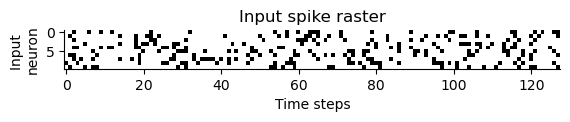

In [80]:
# Define some example spike input

def generate_spikes(b, n_in, t_len):
    torch.manual_seed(20)
    example_spikes = torch.rand(b, n_in, t_len)
    example_spikes[example_spikes > 0.8] = 1
    example_spikes[example_spikes < 1] = 0
    
    return example_spikes

example_spikes = generate_spikes(1, n_in, t_len)
plt.imshow(example_spikes[0], cmap=plt.cm.gray_r)
plt.title("Input spike raster")
plt.xlabel("Time steps")
plt.ylabel("Input \nneuron")
sns.despine()

In [81]:
with torch.no_grad():
    standard_spikes, standard_mem = standard_model(example_spikes, return_type=methods.RETURN_SPIKES_AND_MEM)
    block_spikes, block_mem = block_model(example_spikes, return_type=methods.RETURN_SPIKES_AND_MEM)

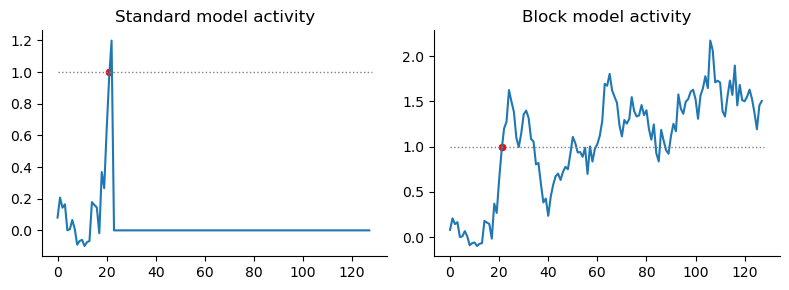

In [82]:
def plot_activity(mem, spikes, ax, title):
    mem = mem.detach()[0, 0]
    ax.plot(mem)
    ax.plot([0, t_len], [1, 1], ":", c="gray", linewidth=1)
    ax.scatter(spikes.argmax()-1, 1, s=20, c="red")
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_activity(standard_mem, standard_spikes, axs[0], "Standard model activity")
plot_activity(block_mem, block_spikes, axs[1], "Block model activity")
sns.despine()
fig.tight_layout()

In the above plots we see that the spike activity (denoted by the red dot) is identical in both the standard single-spike and block model. The membrane potential (blue line) evolves the same up until the point of spike, as in the standard model we set membrane potential to zero after spike (to avoid unecessary compute). However - as a sanity check - if we instruct the standard model to continue integrating membrane potential over time and not reset membrane potential after emitting a spike, we find the membrane potentials to be identical between the standard single-spike and block model.

single_spike True integrator True
recurrent_source None


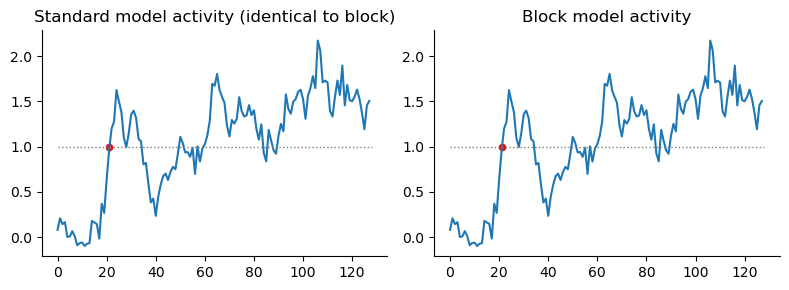

In [83]:
standard_model = LinearNeurons(n_in=n_in, n_out=n_out, method="standard", t_len=t_len, integrator=True, single_spike=True)
standard_model._to_current = block_model._to_current
with torch.no_grad():
    standard_spikes, standard_mem = standard_model(example_spikes, return_type=methods.RETURN_SPIKES_AND_MEM)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_activity(standard_mem, standard_spikes, axs[0], "Standard model activity (identical to block)")
plot_activity(block_mem, block_spikes, axs[1], "Block model activity")
sns.despine()
fig.tight_layout()

## 2. Obtaining faster training speeds using the block model

We have established that the standard and block model are performing the same transformation. Now to justify the use of the block over the standard single-spike model, we benchmark their training speeds, and show that the block is a lot faster to train. We do so by generating some sample batch of input spikes which we pass through both models and record the time it takes for a forward as well as a backward pass (where we just use an arbitraty loss for the backward pass).

In [43]:
import time
import pandas as pd
torch.backends.cudnn.benchmark = True  # Make sure we use the best conv algorithm

In [15]:
sample_training_batch = generate_spikes(128, n_in, t_len)

In [17]:
def get_training_duration(model, device="cpu"):
    start_time = time.time()
    model = model.to(device)
    output = model(sample_training_batch.to(device))
    loss = output.sum()  # Arbitraty loss just so we have something to backpropogate
    loss.backward()
    torch.cuda.synchronize()
    training_duration = time.time() - start_time
    return training_duration

In [19]:
def get_training_durations_for_both_models(device):
    standard_training_times = [get_training_duration(standard_model, device) for _ in range(31)][1:]
    block_training_times = [get_training_duration(block_model, device) for _ in range(31)][1:]
    return pd.DataFrame({"standard": standard_training_times, "block": block_training_times})

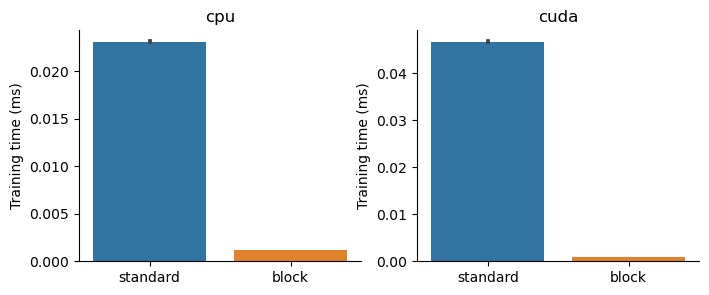

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

def plot_training_durations(ax, device):
    sns.barplot(get_training_durations_for_both_models(device), ax=ax)
    ax.set(ylabel="Training time (ms)", title=device)
    sns.despine()
    
plot_training_durations(axs[0], "cpu")
plot_training_durations(axs[1], "cuda")

In [23]:
print(f"GPU used for the plot above {torch.cuda.get_device_name(0)}.")

GPU used for the plot above NVIDIA GeForce RTX 3090.


We observe that the block model is faster to train than the standard single-spike model on both the CPU and GPU - Cool to see a speedup on a CPU (which was not reported in the paper)! We see that the standard single-spike training durations are larger on the GPU than on the CPU, which is due to size of the dataset used. Larger batch sizes and different number of input/hidden neurons and simulation time steps will yield faster training on a GPU. More generally, varying the paremeters will yield different training speedups in general (as reported in the paper).

## 3. Tackling challenging temporally complex datasets

So the block model speeds up training, but how useful is this model? What sort of problems can we tackle using this model? Single-spike SNNs have shown promising results on static datasets (like classifying spike encoded images), yet have been rumoured to be less suited for temporally complex problems. We demonstrate - with the inclusion of trainable membrane time constants - the block model to perform reasonably well on the temporally challenging auditory SHD dataset.

### 3.1 Block model seems to perform poorly...

Lets train a single hidden layer network with an output layer for predictions. A prediction is generated from the neuron which achieves the largest summated membrane potential over time e.g. we predict class 2 if neuron 2 obtains the largest summated membrane potential over time (see paper for more details).

In [30]:
import os
import logging
from pathlib import Path

import numpy as np
from brainbox.trainer import compute_metric

from block.models import SHDModel
from block.datasets import SHDDataset
from block.datasets.transforms import List
from block.trainer import Trainer

logging.disable("INFO")

# Lets setup those dataset splits
shd_path = os.path.join(Path(os.path.abspath("")).parent, "data/SHD")
train_dataset = SHDDataset(shd_path, train=True, transform=List.get_shd_transform(500))
test_dataset = SHDDataset(shd_path, train=False, transform=List.get_shd_transform(500))

# Little function to calculate accuracies
def get_test_accuracy(model, dataset):
    
    def count_correct(output, target):
        _, predictions = torch.max(output, 1)
        return (predictions == target).sum().cpu().item()
    
    n_correct = compute_metric(model, dataset, count_correct)
    return np.array(n_correct).sum() / len(dataset)

In [ ]:
# Lets instantiate our model and trainer
n_epochs = 80
batch_size = 128
lr = 0.0004
fixed_mem_model = SHDModel("fast_naive", t_len=500, heterogeneous_beta=False, beta_requires_grad=False, readout_max=False)
fixed_mem_trainer = Trainer(None, fixed_mem_model, train_dataset, n_epochs, batch_size, lr)
fixed_mem_trainer.train(save=False)

In [33]:
print(f"Train acc {get_test_accuracy(fixed_mem_model, train_dataset)}")
print(f"Test acc {get_test_accuracy(fixed_mem_model, test_dataset)}")

Train acc 0.24595389897008338
Test acc 0.17977031802120141


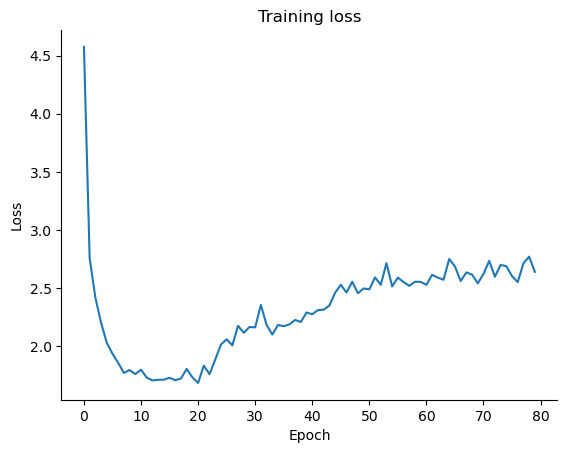

In [47]:
pd.Series(fixed_mem_trainer.log["train_loss"]).plot()
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

Err... Well these numbers do not look so great and these results are a good reminder of what it is like to train spiking neural networks and neural networks in general. There is a lot of finetuning involved to get the magic to work (learning rate, learning rate scheduler, batch size, number of neurons, etc.)! Thankfully, there is a simple modification to obtaining good learning and improved performance: Using trainable instead of fixed membrane time constants!

![](../docs/meme.jpg)

### 3.2 Improving accuracy using trainable membrane time constants

In [63]:
trainable_mem_model = SHDModel("fast_naive", t_len=500, heterogeneous_beta=True, beta_requires_grad=True, readout_max=False)
trainable_mem_trainer = Trainer(None, trainable_mem_model, train_dataset, n_epochs, batch_size, lr)
trainable_mem_trainer.train(save=False)

building layer..
building layer..


In [64]:
print(f"Train acc {get_test_accuracy(trainable_mem_model, train_dataset)}")
print(f"Test acc {get_test_accuracy(trainable_mem_model, test_dataset)}")

Train acc 0.93097106424718
Test acc 0.6598939929328622


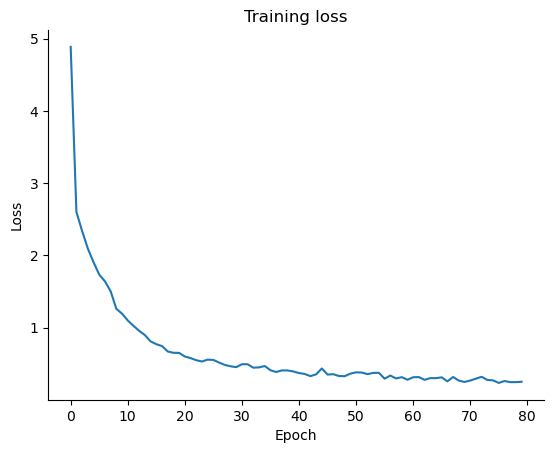

In [65]:
pd.Series(trainable_mem_trainer.log["train_loss"]).plot()
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

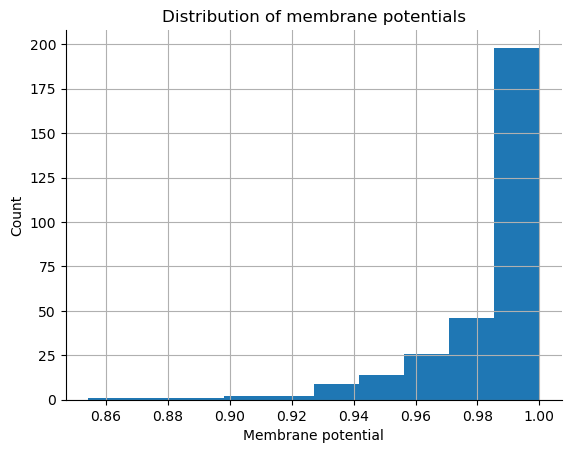

In [74]:
pd.Series(trainable_mem_model._model._layers[0].beta.cpu().detach()).hist()
plt.title("Distribution of membrane potentials")
plt.xlabel("Membrane potential")
plt.ylabel("Count")
sns.despine()

Whoop whoop, the block model is able to obtain a reasonable accuracy on the challenging SHD dataset! We find a monotonically decreasing loss curve and a variety of membrane potential values. However, the discrepancy between the training and testing accuracy hint at an overfit... Some additional training magic will likely raise the test score.